# Gradient-Domain Copy Paste

### CS70 — Foundations of Applied Computer Science
---

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text (using Markdown).

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook  
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

This project explores gradient-domain image processing, a simple technique with a broad set of applications including blending, tone-mapping, and non-photorealistic rendering. For the core project, I will focus on “Poisson blending".


## Background
The primary goal of this project is to seamlessly blend an object or texture from a source image into a target image. The simplest method would be to just copy and paste the pixel values from one image directly into the other. Unfortunately, this will create very noticeable seams, even if the backgrounds are well-matched. How can we get rid of these seams without doing too much perceptual damage to the source region?

![](images/setup.png)

The insight is that our visual system is often more sensitive to the gradient of an image (how quickly the pixel values change left-right and up-down) than the overall intensity. We will therefore set up the problem as finding values for the pasted target pixels that maximally preserve the gradient of the source region without changing any of the background pixels. Note that we are making a deliberate decision here to ignore the overall intensity. So a green hat could turn red, but it will still look like a hat.

## 1D Problem - Fully Constrained
We will first consider a simplified 1D example.

Say we have the following image, and we want to paste it to a new region in the target image. Treat this as a 1D problem, where the bar colors correspond to the following: orange bars are pixels outside the mask, red bars are source pixels to be pasted, and blue bars are the boundary conditions.

![](images/1dproblem.png)

In order to solve this problem, we find the gradients between the original values, write them as constraints, and then solve the system to find the copied values. We then create a system of 4 equations (constraints) and 4 unknowns ($t_{2}, . . . , t_{5}$) to solve this 1D problem. We use $t_{i}$ to refer to the solved value at location $i$ in the image on the right (the four "?" marks) and $s_{i}$ refers to the value in the source image on the left.

We will use finite differences to compute the image gradients. To enforce the gradient constraint, we’d like the differences between neighboring pixels in $t_{1}, . . . , t_{5}$ to match the differences between neighboring pixels in the source image $s_{1}, . . . , s_{5}$. We can express this as the following constraint equations:

$$
\begin{align*}
t2 − t1 &= s2 − s1 \qquad\text{(1)}\\
t3 − t2 &= s3 − s2 \qquad\text{(2)}\\
t4 − t3 &= s4 − s3 \qquad\text{(3)}\\
t5 − t4 &= s5 − s4 \qquad\text{(4)}\\
\end{align*}
$$

### Implementing the fully constrained solution

1. In the planning phase, I wrote out the above constraints on paper in matrix-vector form as $A\mathbf{v} =\mathbf{b}$. We have $4$ unknowns and $4$ equations. The sizes of $A$ and $\mathbf{v}$ were based on the number of unknowns and knowns.
1. I implemented my solution in `fully_constrained_1D` accordingly:
    * Started by populating $A$ and $\mathbf{b}$ with the constraints.
    * Solved the system for the unknowns $\mathbf{v}$ using `np.linalg.solve`.
    * Put the solved values in the appropriate spots in a vector `fully_t` and return it from the function.

**Design Process:** I started by formulating my solution for exactly $4$ unknowns and $4$ constraints. Then, I generalized the function to work for $n$ unknowns and $n$ constraints without using any for loops.

In [122]:
# fully-constrained problem
def fully_constrained_1D(s, t):
    fully_t = np.zeros(t.shape)
    numUnknowns = np.count_nonzero(t == 0)
    
    # constraints
    diag = np.ones((1, numUnknowns))[0]
    diag2 = np.full((1, numUnknowns - 1), -1)[0]
    A = np.diag(diag, 0) + np.diag(diag2, -1)
    
    # knowns
    b = np.vstack(s[1:(numUnknowns + 1)] - s[:numUnknowns])
    b[0] = b[0] + t[0] # modify with start boundary condition
    
    
    # solve for unknowns
    v = np.linalg.solve(A, b)
    v = v.T
    
    # create composite array
    fully_t[1:(numUnknowns+1)] = v[0]
    fully_t = fully_t + t
    
    return fully_t

### Testing the fully-constrained solution

I tested my implementation with the code fragment below.

It starts by initializing vectors `s` and `t` as in the images above (note that we have not included the values at index 0 or 7).
```python
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T
```
It then creates a figure and plots the source and target vectors as two separate bar graphs (using `plt.subplots`, and `.bar`). It also sets a title for each subplot so we know what each one corresponds to.

The code also calls the fully constrained solver. We visualize the results with `.bar` in another subplot. Reference Matplotlib's [.bar documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html), or simply run `help(plt.bar)` to get additional details.

Notice that the gradients have been preserved, but the right boundary does not match up smoothly. We include the expected numerical result as `expected_fully_t`.

<IPython.core.display.Javascript object>


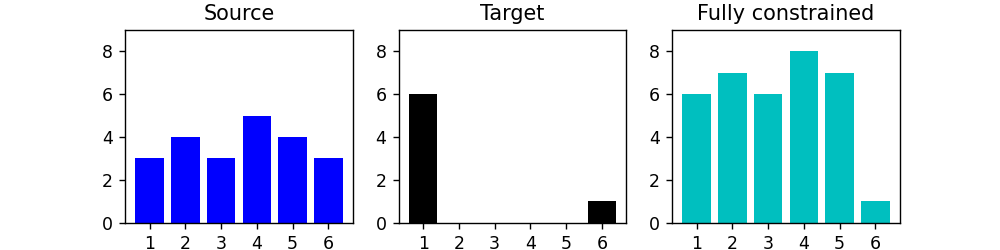

Sum of absolute differences is 0.0


In [123]:
# visualizing 1D solutions
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T

# the expected result
expected_fully_t = np.array([6, 7, 6, 8, 7, 1])

# set up a new figure
fig, axs = plt.subplots(1,3)
# fig.tight_layout(pad=0.0)
fig.set_size_inches(8,2)
ymax = max(max(s),max(t))+3
width = np.arange(1,len(s)+1)

# plot the source and target graphs as subplots
axs[0].bar(width,s,color='b')
axs[0].set_ylim(0,ymax)
axs[0].set_title('Source')
axs[0].set_xticks(width)

axs[1].bar(width,t,color='k')
axs[1].set_title('Target')
axs[1].set_ylim(0,ymax)
axs[1].set_xticks(width)

# compute the fully constrained solutions
fully_t = fully_constrained_1D(s, t)

print(f"Sum of absolute differences is {np.sum(np.abs(fully_t-expected_fully_t))}")

axs[2].bar(width,fully_t,color='c')
axs[2].set_ylim(0,ymax)
axs[2].set_title('Fully constrained')
axs[2].set_xticks(width)

plt.show()

## 1D Problem - Least Squares

We will add in another constraint for this last gradient. Since there is now a 5th constraint but still 4 unknowns, we have an overconstrained system of equations, and we will solve it with least-squares.

The equations will enforce the gradient constraints:

$$
\begin{align*}
t2−t1 &= s2−s1 \qquad\text{(5)}\\
t3−t2 &= s3−s2 \qquad\text{(6)}\\
t4−t3 &= s4−s3 \qquad\text{(7)}\\
t5−t4 &= s5−s4 \qquad\text{(8)}\\
t6−t5 &= s6−s5 \qquad\text{(9)}\\
\end{align*}
$$

### Implementing the least-squares solution

1. In the planning phase, I wrote out the above equations on paper as an over-constrained system in standard matrix form, $\lVert A\mathbf{v} - \mathbf{b} \rVert ^{2}$. We have $4$ unknowns and $5$ equations. Again, the sizes of $A$ and $\mathbf{b}$ were based on the sizes of what is known and not known.
1. Then, I implemented the function `least_squares_1D` below. As before, this function takes the source and target vectors, `s` and `t`, but it will now compute the over-constrained solution for the missing elements of `t`. In `least_squares_1D` we:
  * Populate the constraints into a matrix `A` and vector `b`.
  * Solve the system for the unknowns `v`. We use `np.linalg.lstsq`.
  * Put the solved values in the appropriate spots in a vector `ls_t`, and return it from the function.

**Design Process:** Again, I started by formulating my solution for exactly $4$ unknowns and $4$ constraints. Then, I generalized the function to work for $n$ unknowns and $n$ constraints without using any for loops.

In [124]:
# least-squares version
def least_squares_1D(s, t):
    ls_t = np.zeros(t.shape)
    numUnknowns = np.count_nonzero(t == 0)
    
    # constraints
    diag = np.ones((1, numUnknowns))[0]
    diag2 = np.full((1, numUnknowns), -1)[0]
    A = np.zeros((numUnknowns, numUnknowns)) + np.diag(diag, 0) # add diagonal 1's
    A = np.vstack((A, np.zeros((1, numUnknowns))))
    addDiag2 = np.vstack((np.zeros((1,numUnknowns)), np.diag(diag2, 0)))
    A = A + addDiag2 # add diagonal -1's
    
    # knowns
    b = np.vstack(s[1:s.size] - s[:(s.size - 1)])
    b[0] = b[0] + t[0] # modify with start boundary condition
    b[numUnknowns] = b[numUnknowns] - t[t.size - 1] # modify with end boundary condition
    
    # solve for unknowns
    v = np.linalg.lstsq(A, b, rcond=None)[0]
    v = v.T
    
    # create composite array
    ls_t[1:(ls_t.size - 1)] = v[0]
    ls_t = ls_t + t
    
    return ls_t

### Visualizing the fully-constrained and least-squares solutions

Now we call the over-constrained solver and visualize the results with `.bar` in a fourth subplot to the right of the fully-constrained solution.

Notice that now both the left and right boundaries match nicely, and all gradients have been approximately preserved.

<IPython.core.display.Javascript object>


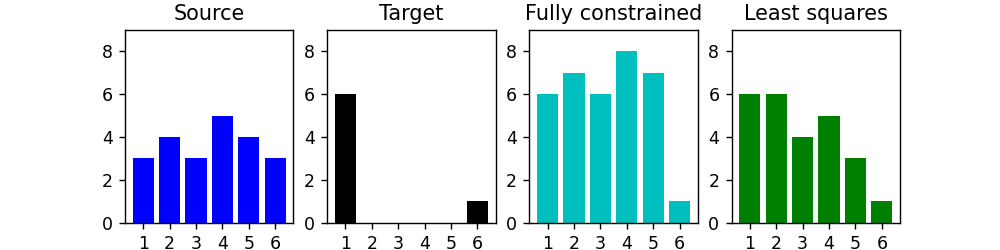

Sum of absolute differences for fully_t is 0.0
Sum of absolute differences for ls_t is 8.881784197001252e-15


In [125]:
# visualizing 1D solutions
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T

# the expected result
expected_fully_t = np.array([6, 7, 6, 8, 7, 1])
expected_ls_t = np.array([6, 6, 4, 5, 3, 1])

fig, axs = plt.subplots(1,4)
# fig.tight_layout(pad=0.0)
fig.set_size_inches(8,2)
ymax = max(max(s),max(t))+3
width = np.arange(1,len(s)+1)

# source
axs[0].bar(width,s,color='b')
axs[0].set_ylim(0,ymax)
axs[0].set_title('Source')
axs[0].set_xticks(width)

# target
axs[1].bar(width,t,color='k')
axs[1].set_title('Target')
axs[1].set_ylim(0,ymax)
axs[1].set_xticks(width)

fully_t = fully_constrained_1D(s, t)
ls_t = least_squares_1D(s, t)

print(f"Sum of absolute differences for fully_t is {np.sum(np.abs(fully_t-expected_fully_t))}")
print(f"Sum of absolute differences for ls_t is {np.sum(np.abs(ls_t-expected_ls_t))}")

# fully constrained
axs[2].bar(width,fully_t,color='c')
axs[2].set_ylim(0,ymax)
axs[2].set_title('Fully constrained')
axs[2].set_xticks(width)

# least squares solution
axs[3].bar(width,ls_t,color='g')
axs[3].set_ylim(0,ymax)
axs[3].set_title('Least squares')
axs[3].set_xticks(width)

plt.show()

## Simple 2D Problem - Least Squares

Now we extend the problem to a simple 2D case, pasting a $2\times2$ region from a $4\times4$ image onto the center of another $4\times4$ image. I noticed this problem is identical to the example from 2/27 lecture but has altered values. We paste the red-bordered region from the source region onto the red-bordered region in the background image.

![](images/2dsimple.png)

1. Planning process: Again, I wrote out all the constraints on paper first like in lecture. We then consider the number of unknowns and constraints.
Recall that for a 1D problem with 2 unknowns, we can write the constraint system as follows:
$$
\begin{align}
t_2−t_1 &= s_2−s_1 \\
t_3−t_2 &= s_3−s_2 \\
t_4−t_3 &= s_4−s_3 \\
\end{align}
$$
Where $t_1$ and $t_4$ are known: they are the corresponding values of the background image. We have one such set of constraints for each row and for each column in the $2\times2$ block of unknown pixel values.

1. Next, we convert these equations into standard matrix form.

1. Finally, we implement the solution in `least_squares_simple_2D` below as follows:

    1. start by initialize two matrices, `source_im` and `background_im`, as follows:
```python
source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 150, 100],
                          [100, 150, 100, 100],
                          [100, 100, 100, 100]])
background_im = np.array([[10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10]])
```

    1. Now that we are working in 2D, it becomes a bit harder to keep track of which pixels correspond to which elements in our unknown vector. To help keep track of this, we create a matrix `im2var` that maps each pixel of interest to a variable number such as: `np.arange(0, 4).reshape(2, 2)`. Then we copy this matrix onto the inner region of a $4\times4$ matrix so that accessing a variable number given an `x`, `y` coordinate is simple. We will use these variable numbers to access the correct column in $A$ when adding constraints.

    1. Then we initialize matrix $A$ as a sparse matrix using the imported `lil_matrix` (see the [LIL matrix documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) or just type `help(lil_matrix)`) and vector $\mathbf{b}$ to the correct dimensions.

    1. We then add constraints to $A$ and $\mathbf{b}$ by considering each row and each column of unknowns one by one. Each row and column leads to a set of constraints (rows in the matrix $A$). For example, we can write the left boundary constraint for the first row as:
```python
A[0, im2var[1, 1]] = 1
b[0] = source_im[1, 1] - source_im[1, 0] + background_im[1, 0]
```

    1. Sparse matrices are best initialized as LIL matrices but perform matrix vector operations better as a CSR matrix. We first convert $A$ to a CSR matrix using `A = A.tocsr()` and solve for $\mathbf{v}$ using `v = sla.lsqr(A, b)[0]`. Then we reshape $\mathbf{v}$ to the correct dimensions and copy its values to a copy of `background_im`. We return a 3-tuple: `source_im, background_im, im_out`.

<IPython.core.display.Javascript object>


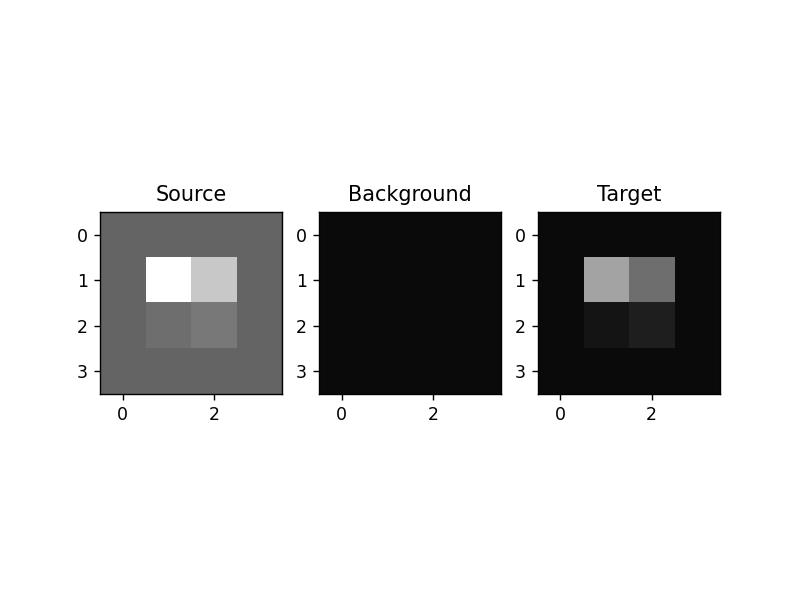

[[ 10  10  10  10]
 [ 10 164 110  10]
 [ 10  20  30  10]
 [ 10  10  10  10]]


In [136]:
def least_squares_simple_2D():

    source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 200, 100],
                          [100, 110, 120, 100],
                          [100, 100, 100, 100]])
    background_im = np.array([[10, 10, 10, 10],
                                [10, 10, 10, 10],
                                  [10, 10, 10, 10],
                                  [10, 10, 10, 10]])
    t = background_im.copy()

    A = lil_matrix((12, 4)) # initializes sparse constraints matrix
    b = np.zeros((12, 1)) # initializes knowns matrix
    
    # maps each pixel of interest to an x,y coordinate in a 4x4 matrix
    im2var = np.zeros((4, 4))
    im2var_inner = np.arange(0, 4).reshape(2, 2)
    im2var[1:3, 1:3] = im2var_inner
    
    # Add constraints to A and b
    
    # 1st row horizontal
    A[0, im2var[1, 1]] = 1
    b[0] = source_im[1, 1] - source_im[1, 0] + background_im[1, 0]
    A[1, im2var[1, 1]] = -1
    A[1, im2var[1, 2]] = 1
    b[1] = source_im[1, 2] - source_im[1, 1]
    A[2, im2var[1, 2]] = -1
    b[2] = source_im[1, 3] - source_im[1, 2] - background_im[1, 3]

    # 2nd row horizontal
    A[3, im2var[2, 1]] = 1
    b[3] = source_im[2, 1] - source_im[2, 0] + background_im[2, 0]
    A[4, im2var[2, 1]] = -1
    A[4, im2var[2, 2]] = 1
    b[4] = source_im[2, 2] - source_im[2, 1]
    A[5, im2var[2, 2]] = -1
    b[5] = source_im[2, 3] - source_im[2, 2] - background_im[2, 3]

    # 1st column vertical
    A[6, im2var[1, 1]] = 1
    b[6] = source_im[1, 1] - source_im[0, 1] + background_im[0, 1]
    A[7, im2var[1, 1]] = -1
    A[7, im2var[2, 1]] = 1
    b[7] = source_im[2, 1] - source_im[1, 1]
    A[8, im2var[2, 1]] = -1
    b[8] = source_im[3, 1] - source_im[2, 1] - background_im[3, 1]

    # 2nd column vertical
    A[9, im2var[1, 2]] = 1
    b[9] = source_im[1, 2] - source_im[0, 2] + background_im[0, 2]
    A[10, im2var[1, 2]] = -1
    A[10, im2var[2, 2]] = 1
    b[10] = source_im[2, 2] - source_im[1, 2]
    A[11, im2var[2, 2]] = -1
    b[11] = source_im[3, 2] - source_im[2, 2] - background_im[3, 2]
    
    # solve for unknowns
    A = A.tocsr()
    v = sla.lsqr(A, b)[0]
    v = v.reshape((2, 2))

    # create target image
    t[1:3, 1:3] = v

    return source_im, background_im, t

source, background, target = least_squares_simple_2D() # store source, background, and target images
fig, axs = plt.subplots(1,3) # initialize subplots

# display source image
axs[0].set_title('Source')
axs[0].imshow(source, cmap='gray', vmin=0, vmax=255)

# display background image
axs[1].set_title('Background')
axs[1].imshow(background, cmap='gray', vmin=0, vmax=255)

# display target image
axs[2].set_title('Target')
axs[2].imshow(target, cmap='gray', vmin=0, vmax=255)
print(target) # print target array (for checking)

plt.show()



After the implementation of `least_squares_simple_2D`, I ran it and visualized the results by using `imshow` with optional parameters `cmap='gray', vmin=0, vmax=255`. I visually verified that the result image preserves the *gradient* of the source image without changing any of the background pixels. The expected numerical result provided in class is listed below (for comparison).

In [ ]:
expected = np.array([[ 10,  10,  10,  10],
                     [ 10, 164, 110,  10],
                     [ 10,  20,  30,  10],
                     [ 10,  10,  10,  10]])


## Generalized 2D Problem - Least Squares

Next, we generalize the 2D problem. We implement `least_squares_2D`, which takes two parameters, `im_s` and `im_background`, each of which have dimensions $(W + 2) \times (H + 2)$ and returns the interior region (dimensions $W \times H$) of `im_s` pasted onto the interior region of `im_background`. 

Much like in the simple 2D problem, first we create a matrix `im2var` to map each pixel of interest to a variable number. We initialize `A` and `b` to the correct dimensions. Of note, `A` is initialized as a sparse matrix using `lil_matrix`, because the alternative of solving with `sla.lsqr` would take a long time. 

We use a variable `e` as an equation counter. We also add constraints to `A` and `b` in a similar way to the simple 2D problem, by considering each row and column of the block of unknown pixels one by one. We considered but did not implement helper functions as recommended in office hours. These helper functions would have added an entire column's vertical constraints or an entire row's horizontal constraints to `A`.

Once we filled `A` and `b` with the constraints, we used the imported `time` function to time how long it took to solve for `v1` using `sla.lsqr`.

```python
t = time.time() # start timer
... # code here
elapsed = time.time() - t # end timer
```

We compared this to how long it would take to instead solve for `v2` by forming the normal equations. Then we created a dense matrix `ATA = (A.T@A).toarray()` and a dense vector `ATb = A.T@b`, and solved the dense system $(A^TA)\mathbf{v}_2 = (A^T\mathbf{b})$ using `np.linalg.solve`.

The descriptive text `print('Solving sparse system with sla.lsqr')` and `print('Solving dense normal equations')` prints prior to each operation, then we print the elapsed time for each method.

We paste reshaped versions of `v1` and `v2` onto copies of `im_background` and return the resultant images as a 2-tuple: `im_blend1, im_blend2`. 

Solving sparse system with sla.lsqr
Elapsed time: 0.181321
Solving dense normal equations
Elapsed time: 8.153196


<IPython.core.display.Javascript object>


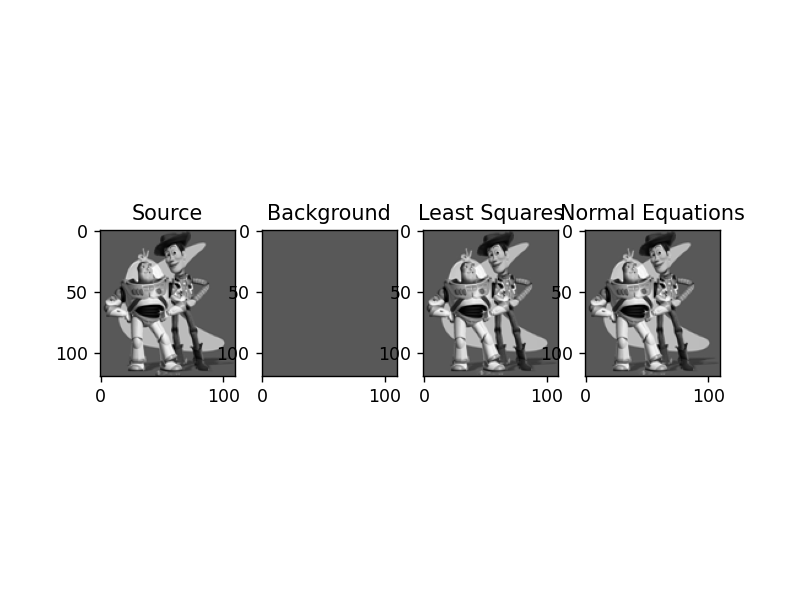

Mean squared error: 0.000009


In [222]:

# I decided against using these helper functions because I was unsure how to implement them without overcomplicating
# my solution. I did manage to implement the solution in the the least_squares_2D method itself
def add_vertical_constraint(im_s, im_background, im2var, A, b, e, x):
    #
    # TODO: add code here
    #
    return e
    
    
def add_horizontal_constraint(im_s, im_background, im2var, A, b, e, y):
    #
    # TODO: add code here
    #
    return e

# generalized 2D
def least_squares_2D(im_s, im_background, do_normal=True):
    
    # initialize results to just be copies of the background
    # if do_normal == False, skip doing the more expensive normal equation solve
    im_blend1 = im_background.copy()
    im_blend2 = im_background.copy()
    
    # map each pixel of interest to an x,y coordinate in the larger matrix
    H, W = im_s.shape # num_rows, num_columns
    im2var = np.zeros((H, W))
    H -= 2 # refit to interior region
    W -= 2
    numUnknowns = H * W
    im2var_inner = np.arange(0, numUnknowns).reshape(H, W)
    im2var[1:(H+1), 1:(W+1)] = im2var_inner
    # have created im2var
    
    # calculate number of constraints
    num_constraints = 4 # init to constraints of 1x1
    h_temp = 1
    for i in range(1, W):
        num_constraints = num_constraints + (2*h_temp) + 1
    # now at total width so don't use w_temp
    for j in range(1, H):
        num_constraints = num_constraints + (2*W) + 1
    
    
    A = lil_matrix((num_constraints, numUnknowns)) # initializes sparse constraints matrix
    
    
    b = np.zeros((num_constraints, 1)) # initializes knowns matrix
    
    # populates A and b
    index = 0
    while index < num_constraints:
        row = 1
        # horizontal constraints
        while row <= H:
            col = 1
            while col <= (W+1):
                b[index] = im_s[row, col] - im_s[row, col-1] + im_background[row, col-1] # left boundary
                A[index, im2var[row, 1]] = 1
                index+=1
                col += 1 # loop this
                # middle, fill this out
                while col < (W+1):
                    A[index, im2var[row, col]] = 1
                    A[index, im2var[row, col-1]] = -1
                    b[index] = im_s[row, col] - im_s[row, col-1]
                    index += 1
                    col += 1
                b[index] = im_s[row, col] - im_s[row, col-1] - im_background[row, col] # right boundary
                A[index, im2var[row, W]] = -1
                index += 1
                col += 1
            row += 1
        row = 1
        col = 1
        # vertical constraints
        while col <= W:
            row = 1
            while row <= (H+1):
                b[index] = im_s[row, col] - im_s[row-1, col] + im_background[row-1, col] # left boundary
                A[index, im2var[1, col]] = 1 
                index += 1
                row += 1
                # middle
                while row < (H+1):
                    A[index, im2var[row, col]] = 1
                    A[index, im2var[row-1, col]] = -1
                    b[index] = im_s[row, col] - im_s[row-1, col]
                    index += 1
                    row += 1
                b[index] = im_s[row, col] - im_s[row-1, col] - im_background[row, col] # right boundary
                A[index, im2var[H, col]] = -1
                index += 1
                row += 1
            col += 1
    # A and b should be filled out by now
    
    # solve for unknowns using lsq
    A = A.tocsr()
    print('Solving sparse system with sla.lsqr')
    t = time.time() # start timer
    v1 = sla.lsqr(A, b)[0]
    elapsed = time.time() - t # end timer
    print("Elapsed time: %f" % elapsed)
    v1 = v1.reshape((H, W))
    im_blend1[1:(H+1), 1:(W+1)] = v1 # create target lsq image
    
    # solve for unknowns using normal equations
    if do_normal:
        print('Solving dense normal equations')
        ATA = (A.T@A).toarray()
        ATb = A.T@b
        t = time.time() # start timer
        v2 = np.linalg.solve(ATA, ATb)
        elapsed = time.time() - t # end timer
        print("Elapsed time: %f" % elapsed)
        v2 = v2.reshape((H, W))
        im_blend2[1:(H+1), 1:(W+1)] = v2 # create target image using normal equations

    return im_blend1, im_blend2

# load in source, background images
toyim = plt.imread('images/toy_problem.png')
im_background = np.full(toyim.shape, toyim[0][0])

# create least squares images
im1, im2 = least_squares_2D(toyim, im_background, True)

fig, axs = plt.subplots(1,4) # initialize subplots

# display source image
axs[0].set_title('Source')
axs[0].imshow(toyim, cmap='gray')

# display background image
axs[1].set_title('Background')
axs[1].imshow(im_background, cmap='gray', vmin = 0, vmax = 1)

# display lsq image
axs[2].set_title('Least Squares')
axs[2].imshow(im1, cmap='gray', vmin=0, vmax=1)

# display normal equations image
axs[3].set_title('Normal Equations')
axs[3].imshow(im2, cmap='gray', vmin=0, vmax=1)

# calculate error
MSE = np.square(np.subtract(im1.reshape((1, im1.size)), toyim.reshape((1, toyim.size)))).mean()
print("Mean squared error: %f" % MSE)

plt.show()



We load `toyim = plt.imread('images/toy_problem.png')` and create `im_background` by creating a matrix with the same dimensions as `toyim` filled with the value at the top left corner of `toyim` using np.full [see numpy.full documentation](https://numpy.org/doc/stable/reference/generated/numpy.full.html). 

We test `least_squares_2D` by reconstructing `toyim`. Then we run `least_squares_2D` on `toyim` and `im_background`, and display the two reconstructed images with titles. (other notes: we also pass `imshow` the optional parameter `cmap = 'gray'`). 

Additionally, we provide the error value between the reconstructed image(either) and the original image as a printed statement.

## Poisson Blending

For Poisson Blending, we select a coordinate on the background image which serves as the bottom right corner for an object image to be blended into the background image. Ideally, the background of the object image and the surrounding area of the target region will be of similar color. To test, run the following cell and select the coordinates for the gradient blend by clicking on the interactive figure. The interactive figure should draw a rectangle where the object image will appear in the blended image.

<IPython.core.display.Javascript object>


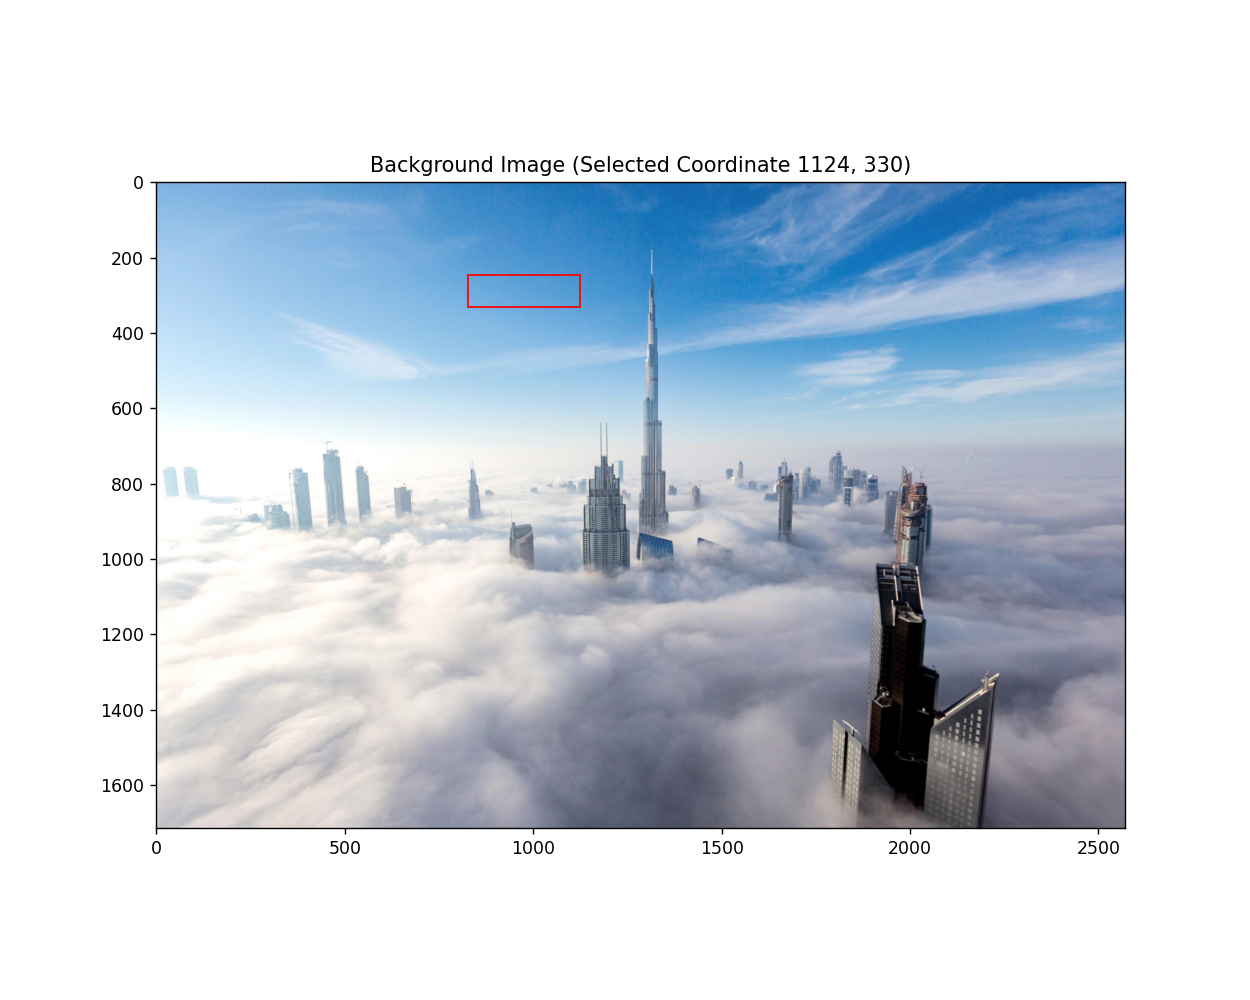

In [224]:
## new gradient domain copy-paste code should go here
# read in background and object images (provided)
#im_background = plt.imread('images/background.jpg')/255.0
#im_object = plt.imread('images/penguin-chick.jpg')/255.0

# my images
im_background = plt.imread('images/burj_CNN.jpg')/255.0
im_object = plt.imread('images/emirates2.jpg')/255.0

#
# reduce the size of the image for faster performance while debugging
# can comment these two lines out to use the full-resolution images
#im_background = resize(im_background, (im_background.shape[0] // 5, im_background.shape[1] // 5), anti_aliasing=True)
#im_object = resize(im_object, (im_object.shape[0] // 5, im_object.shape[1] // 5), anti_aliasing=True)
#
#


# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image)")
plt.show()

The method below `simple_copy_paste` copies the pixel values from `im_object` onto the appropriate location of `im_background`. It was provided by the TA's.

We implement `poisson_copy_paste` which takes three parameters: `coords`, the coordinates of the bottom right corner of the region to blend, `im_object`, the image to paste into the background image, and `im_background`, the unaltered background image. 

We cut out the appropriate region of `im_background` and solve for all three channels of the blended region using `least_squares_2D`. We then paste the results back into the appropriate region of a copy of `im_background` and return a tuple of two images, one from solving with the `sla.lsqr` and the other from solving with the normal equations.

In [225]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background, do_normal=True):
    # pass do_normal to least_squares_2d
    x, y = coords
    objh, objw, _ = im_object.shape

    res1 = im_background.copy()
    res2 = im_background.copy()
    
    # use least squares to match gradients of object image to background for each color
    red_lsq, red_norm = least_squares_2D(im_object[:,:,0], im_background[y-objh:y, x-objw:x, 0], True)
    green_lsq, green_norm = least_squares_2D(im_object[:,:,1], im_background[y-objh:y, x-objw:x, 1], True)
    blue_lsq, blue_norm = least_squares_2D(im_object[:,:,2], im_background[y-objh:y, x-objw:x, 2], True)
    
    # combine red, green, and blue channels
    rgb_lsq = np.dstack((red_lsq, green_lsq, blue_lsq)) # stack along 3rd axis
    rgb_norm = np.dstack((red_norm, green_norm, blue_norm)) # stack along 3rd axis
    
    # paste least squares images into background images
    res1[y-objh:y, x-objw:x, :] = rgb_lsq # least squares solution
    res2[y-objh:y, x-objw:x, :] = rgb_norm # normal equations solution

    return res1, res2

Finally we ran `poisson_copy_paste` and you can see the blended images below. Note that we restricted the blended image values to between 0 and 1 by calling `.clip(0,1)` on the blended images.

Solving sparse system with sla.lsqr
Elapsed time: 0.628273
Solving dense normal equations
Elapsed time: 62.525505
Solving sparse system with sla.lsqr
Elapsed time: 0.573467
Solving dense normal equations
Elapsed time: 68.249953
Solving sparse system with sla.lsqr
Elapsed time: 0.693147
Solving dense normal equations
Elapsed time: 68.706325


<IPython.core.display.Javascript object>


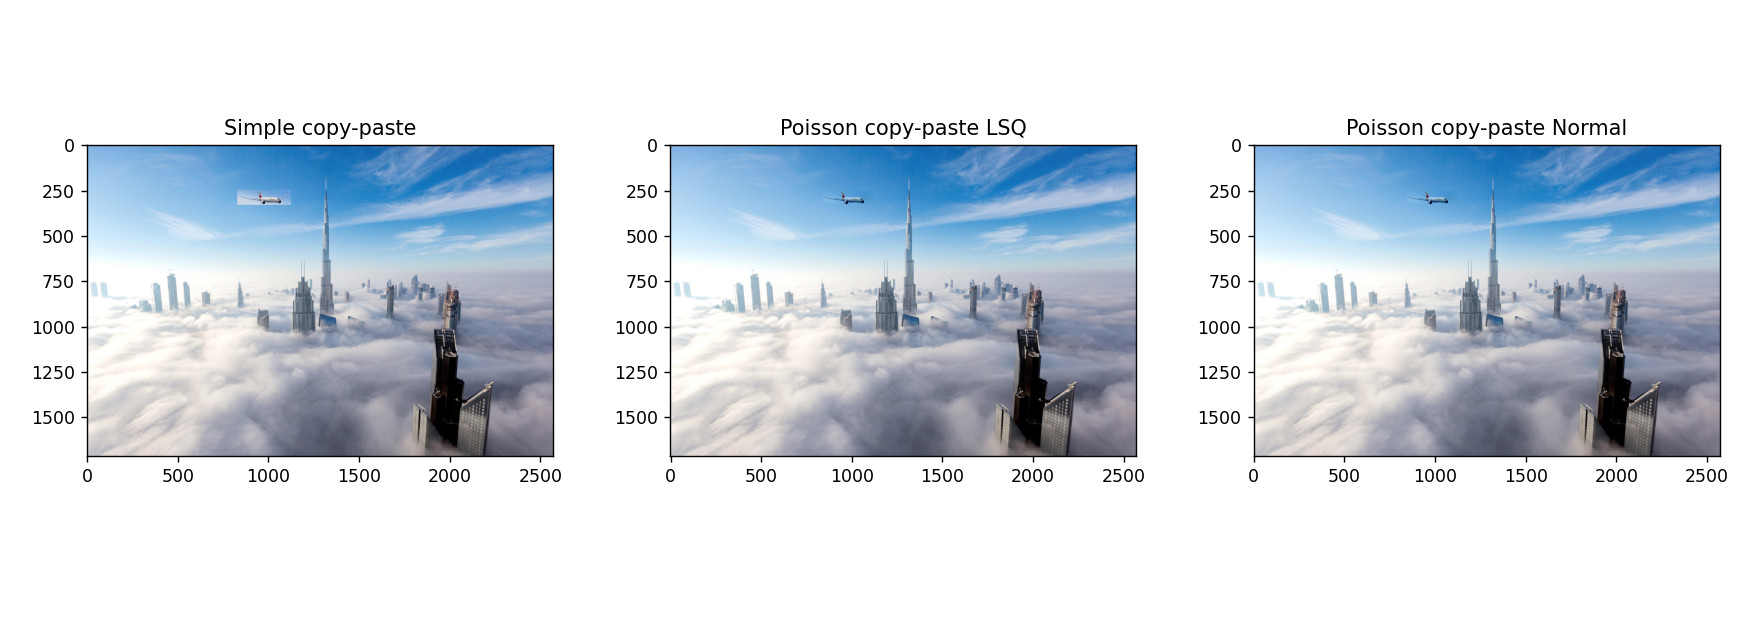

In [226]:
res0 = simple_copy_paste(coords, im_object, im_background)
res1, res2 = poisson_copy_paste(coords, im_object, im_background, True)
res1 = res1.clip(0, 1)
plt.imsave("flying_burj.jpg", res1)

fig3, axs3 = plt.subplots(1,3)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple copy-paste")

# poisson least squares
axs3[1].imshow(res1.clip(0, 1))
axs3[1].set_title("Poisson copy-paste LSQ")

# poisson normal equations
axs3[2].imshow(res2.clip(0, 1))
axs3[2].set_title("Poisson copy-paste Normal")

plt.show()

## Run your own Poisson Blending
A user of this program can blend two images of their choice using `poisson_copy_paste`. Change the images used in the code blocks above, and comment out the default images, which should look something like this:

```python
#im_background = plt.imread('images/background.jpg')/255.0
#im_object = plt.imread('images/penguin-chick.jpg')/255.0
im_background = plt.imread('images/your_background.jpg')/255.0
im_object = plt.imread('images/your_object.jpg')/255.0
```

Make sure the images are stored in the images folder so path is still correct (else modify the path).

## References
This project is based off of a [similar one](http://graphics.cs.cmu.edu/courses/15-463/2010_fall/hw/proj2g/) from CMU.